In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 簡化版的deep q learning： 僅把q-table換成類神經網路
＃在Reinforcement Learning中我們都利用Q_target（把它當作真實的Q值)來更新神經網路的weights。
公式： Q_target = Q(s) + alpha*( R(s,a) + Q(s_)*Gamma-Q(s) )  
(s_ 代表下一步的狀態，下一步的狀態有很多種可能，我們這裡選擇的s_是能得到最大Q的狀態，這種方法是比較agressive的方法，還有另外一種是SARSA有興趣可以自尋搜尋一下； alpha這邊我們設定為1）
因此公式就變成 Q_target = R(s,a) + max(Q(s_,a))*Gamma  

In [2]:
class QLearning:
    
    def __init__(
        self, 
        n_actions, #動作的維度，例如上下左右就有四維
        n_states, #用來描述狀態的維度，例如馬力歐在平面上就是二維
        gamma = 0.9, #遠見程度
        epsilon = 0.9,  #保守程度，越大就越容易用Q值大小來採取行動；越小則越容易產生隨機行動
        learning_rate = 0.001 #神經網路的更新率
    ):
    
        self.n_actions = n_actions
        self.n_states = n_states
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = learning_rate
        
        tf.reset_default_graph() ## 重新 build graph 需要跑這行
        self.sess = tf.Session() #宣告session
        #輸入current state
        self.state_input = tf.placeholder(shape = [None, self.n_states], 
                                          name = 'input',
                                          dtype = tf.float32)
        #q_target = R(s, action) + Q(s_)*Gamma 
        self.q_target = tf.placeholder(shape = [None, self.n_actions], 
                                       name = 'q_target',
                                       dtype = tf.float32)
        #搭建神經網路
        with tf.variable_scope('Q_table'):
            self.q_eval = self.build_network('net_eval') 
        
        # 管理神經網路的parameters
        self.Qnet_eval_params = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='Q_table/net_eval')
        
        #計算q_target和q_eval的mse來更新神經網路的參數
        self.loss = tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        self.train = tf.train.RMSPropOptimizer(self.lr).minimize(self.loss, var_list=self.Qnet_eval_params)
        
        self.sess.run(tf.global_variables_initializer()) #將神經網路初始化
        
            
    def build_network(self, scope): 
        with tf.variable_scope(scope):
            x_h1 = tf.layers.dense(inputs = self.state_input, units = 5, activation = tf.nn.tanh)        
            x_h2 = tf.layers.dense(inputs = x_h1, units = 5, activation = tf.nn.tanh)             
        return tf.layers.dense(inputs = x_h2, units = self.n_actions) #輸出‘不同動作’對應的Q值 
               
 
            
    def choose_action(self, current_state):
        """
        利用epsilon來控制探索的隨機程度，通常探索初期會給比較小的epsilon增加行為的隨機程度，
        然後隨著遊戲的進行慢慢增加epsilon。不過由於這裡的遊戲較簡單，就不做此設定。
        """
        if np.random.uniform() < self.epsilon: 
            #選擇產生估計Q值較大的行動
            q_eval = self.sess.run(self.q_eval, feed_dict={self.state_input: current_state[np.newaxis, :]})
            self.action = np.argmax(q_eval)
        else:
            #採取隨機行動
            self.action = np.random.randint(0, self.n_actions)
        return self.action
    
    def learn(self, current_state, reward, next_state):
        
        #算出實際q值並用此更新神經網路參數
        q_eval = self.sess.run(self.q_eval, feed_dict={self.state_input: current_state[np.newaxis, :]})
        q_eval_next = self.sess.run(self.q_eval, feed_dict={self.state_input: next_state[np.newaxis, :]})
        q_target = q_eval.copy()
        q_target[:, self.action] = reward + self.gamma*q_eval_next.max()
        _, self.cost = self.sess.run([self.train, self.loss], feed_dict={self.state_input: current_state[np.newaxis, :],
                                                                            self.q_target: q_target})
    def model_save(self, model_name):
        
        saver = tf.train.Saver()
        saver.save(self.sess, "saved_models/{}.ckpt".format(model_name))
    
    def model_restore(self, model_name):
        
        saver = tf.train.Saver()
        saver.restore(self.sess, "saved_models/{}.ckpt".format(model_name))
    

In [3]:
def training(save_model, model_name):
    reward_record = []
    for episode in range(50):
        # initial environment並給出起始的state
        total_reward = 0
        current_state = env.reset()

        while True:
            # 產生環境視窗
            env.render()

            # RL choose action based on current state
            action = RL.choose_action(current_state)

            # RL take action and get next state and reward
            next_state, reward, done = env.step(action)
            
            total_reward+= reward
            
            RL.learn(current_state, reward, next_state)
            
            # swap state
            current_state = next_state

            # break while loop when end of this episode
            if done:
                print('Total Reward:{}'.format(total_reward))
                reward_record.append(total_reward)
                break

    # end of game
    if save_model:
        RL.model_save(model_name)
    print('game over')
    env.close()
    return reward_record

# 調整gamma並觀察學習情況

In [4]:
import os
os.sys.path.append('environment/')
import Mario2
reward_result = []
for i in range(5):     
    env = Mario2.make()
    RL = QLearning(n_actions = env.n_actions, 
                   n_states = env.n_features,
                   gamma = (i*2+1)/10,
                   epsilon = 0.9,
                   learning_rate = 0.01
                   )
    print('episode{} start: gamma={}'.format(i, (i*2+1)/10))
    reward_record = training(save_model = True, model_name='gamma_p{}'.format(i*2+1))
    reward_result.append(pd.DataFrame(data = reward_record))

episode0 start: gamma=0.1
Total Reward:-14.799999999999967
Total Reward:-11.999999999999968
Total Reward:-9.799999999999978
Total Reward:-0.8000000000000005
Total Reward:0.5
Total Reward:-1.5000000000000004
Total Reward:-20.700000000000053
Total Reward:-28.800000000000114
Total Reward:-16.499999999999986
Total Reward:-146.99999999999596
Total Reward:-71.20000000000013
Total Reward:-7.399999999999986
Total Reward:-7.299999999999994
Total Reward:-0.40000000000000036
Total Reward:-0.6000000000000003
Total Reward:-2.100000000000001
Total Reward:-6.499999999999994
Total Reward:-1.4000000000000012
Total Reward:-0.40000000000000036
Total Reward:-0.40000000000000013
Total Reward:-0.6000000000000001
Total Reward:-0.40000000000000013
Total Reward:-0.40000000000000013
Total Reward:0.5
Total Reward:-0.40000000000000013
Total Reward:0.20000000000000007
Total Reward:0.5
Total Reward:0.5
Total Reward:0.5
Total Reward:0.5
Total Reward:0.5
Total Reward:0.5
Total Reward:-0.40000000000000036
Total Reward

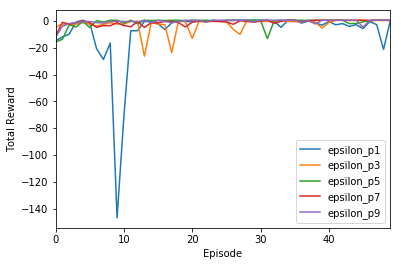

In [5]:
reward_result = pd.concat(reward_result, axis=1)
reward_result.columns = ['Gamma_p{}'.format(x*2+1) for x in range(5)]
reward_result.plot()
plt.xlabel('Gamma')
plt.ylabel('Total Reward')
plt.show()